# Boosted GRU model for price prediction

## 0. Assumptions of the model

We will use an encoder-decoder made of GRU cells, boosted with other features included in the dataset

## 1. Packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf  
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
print('Imported tensorflow', tf.VERSION)

Imported tensorflow 1.11.0


In [2]:
# import folder scripts
from feature_selection_feed import top_correlated, reformat_as_sequence
from evaluation import score_mape

## 2. Data Source

In [3]:
df = pd.read_csv('metals_daily_train.csv')
df = df.dropna(axis=0)

In [4]:
df.head()

,date,p0,p1,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,...,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle,week,week_date
109,20081201,444.511058,457.032497,457.032497,53.08,56.33,52.62,56.29,49.11,52.15,...,9420.0,9680.0,9315.0,9540.0,9520.0,9800.0,9495.0,9650.0,2030,20081201
110,20081202,446.908899,465.530103,459.323035,55.99,56.29,54.68,55.30,51.80,52.24,...,9480.0,9600.0,9430.0,9510.0,9640.0,9730.0,9560.0,9630.0,2030,20081201
111,20081203,453.484820,482.060575,459.696940,56.50,56.72,54.65,55.21,53.01,53.02,...,9495.0,9580.0,9400.0,9500.0,9530.0,9690.0,9505.0,9590.0,2030,20081201
112,20081204,447.532919,472.395859,459.964389,55.50,57.81,54.88,57.62,51.75,54.42,...,9485.0,9485.0,9120.0,9145.0,9400.0,9445.0,9205.0,9225.0,2030,20081201
113,20081205,447.084228,471.922241,459.503235,58.50,60.00,56.63,56.75,54.70,56.18,...,8710.0,9000.0,8595.0,8665.0,8885.0,8940.0,8670.0,8715.0,2030,20081201


# 2Bis. Boosted data source

In [5]:
df = pd.read_csv('metals_daily_train.csv')
df = df.dropna(axis=0)

selected_features = top_correlated(df, 50, 0.75)
selected_features = selected_features.insert(0, 'date')

df_ref = reformat_as_sequence(df, 100, 50)
df_ref.head()

,date_t,p1_(t-99),p1_(t-98),p1_(t-97),p1_(t-96),p1_(t-95),p1_(t-94),p1_(t-93),p1_(t-92),p1_(t-91),...,p1_(t+41),p1_(t+42),p1_(t+43),p1_(t+44),p1_(t+45),p1_(t+46),p1_(t+47),p1_(t+48),p1_(t+49),p1_(t+50)
100,20090515.0,457.032497,465.530103,482.060575,472.395859,471.922241,472.073147,472.134908,472.519568,473.139085,...,512.965645,516.764439,516.749309,516.772004,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451
101,20090519.0,465.530103,482.060575,472.395859,471.922241,472.073147,472.134908,472.519568,473.139085,467.806318,...,516.764439,516.749309,516.772004,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451,556.722797
102,20090520.0,482.060575,472.395859,471.922241,472.073147,472.134908,472.519568,473.139085,467.806318,468.585995,...,516.749309,516.772004,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451,556.722797,556.771695
103,20090521.0,472.395859,471.922241,472.073147,472.134908,472.519568,473.139085,467.806318,468.585995,474.348364,...,516.772004,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451,556.722797,556.771695,556.804299
104,20090522.0,471.922241,472.073147,472.134908,472.519568,473.139085,467.806318,468.585995,474.348364,493.223915,...,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451,556.722797,556.771695,556.804299,560.517007


In [6]:
# number of trend features that will help prediction
trend_memory = len(selected_features) - 1

In [7]:
def trend_bins(df, lag, block=None):
    """Return categories of trend (-1, 0, +1) over the last lag days at each date"""
    # compute slopes 
    slopes = []
    for t in range(lag, len(df)):
        linreg = LinearRegression()
        linreg.fit(np.arange(lag).reshape(-1, 1), df.iloc[(t-lag):t].values)
        slopes.append(list(linreg.coef_.flatten()))
    df_slopes = pd.DataFrame(slopes, columns=df.columns)
    
    # categorize slopes
    df_copy_slopes = df_slopes.copy()
    for col in df.columns:
        if col not in block:
            thre_low = np.quantile(df_copy_slopes[col].values, 0.33)
            thre_high = np.quantile(df_copy_slopes[col].values, 0.66)
            df_slopes[col] = 0
            df_slopes[col][df_copy_slopes[col] >= thre_high] = 1
            df_slopes[col][df_copy_slopes[col] <= thre_low] = -1
            
    df_slopes = df_slopes.drop(block, axis=1)
    for col in block:
        df_slopes[col] = df[col].values[lag:len(df)]
        
    return df_slopes

In [8]:
# prepare for join
df_trends = trend_bins(df[selected_features], 50, block=['date'])
df_trends = df_trends.set_index('date')
df_ref = df_ref.set_index('date_t')
df_trends.index.astype('float64')

# join
df_boosted = df_trends.join(df_ref, how='inner')
df_boosted = df_boosted.reset_index()
df_boosted = df_boosted.drop('index', axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-cop

In [9]:
def fetch_sample_boosted(df, batch_size, input_seq_len, output_seq_len, random_state=None):
    """Get a batch from the dataframe. 
    
    Each batch contains batch_size sequences. 
    Each sequences is made of input_seq_len values and the follwing output_seq_len 
    values of the time series.
    """
    X_batch = []
    y_batch = []
    n = df.shape[0]
    np.random.seed(random_state)
    rs = np.random.randint(0, n-df.shape[1], batch_size)
    for _, r in zip(range(batch_size), rs):
        X_batch.append(df.iloc[r, :-output_seq_len].values.reshape(-1, 1))
        y_batch.append(df.iloc[r, -output_seq_len:].values.reshape(-1, 1))
    X_batch = np.array(X_batch)
    X_batch = np.array(X_batch).transpose((1, 0, 2))
    y_batch = np.array(y_batch).transpose((1, 0, 2))
    return X_batch, y_batch

In [10]:
# just an example
fetch_sample_boosted(df_boosted, 2, 100, 5, random_state=5)

(array([[[ -1.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  0.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  0.       ]],
 
        [[ -1.       ],
         [  0.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  0.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[  0.       ],
         [  1.       ]],
 
        [[  0.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[ -1.       ],
         [  1.       ]],
 
        [[  1.       ],
         [  1.       ]],
 
        [[559.7102754],
         [485.689497 ]],
 
        [[562.6184014],
         [485.7535252]],
 
        [[562.6904985],
       

In [11]:
def normalize(df):
    scaler = StandardScaler()
    values = df.values
    values = scaler.fit_transform(values)
    return pd.DataFrame(values), scaler

In [12]:
df_boosted.head(5)

,p1,f091_settle,f029_settle,f090_settle,f131_settle,f132_settle,f130_settle,f133_settle,f028_settle,f135_settle,...,p1_(t+41),p1_(t+42),p1_(t+43),p1_(t+44),p1_(t+45),p1_(t+46),p1_(t+47),p1_(t+48),p1_(t+49),p1_(t+50)
0,0,1,1,1,1,1,1,1,1,1,...,512.965645,516.764439,516.749309,516.772004,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451
1,0,1,1,1,1,1,1,1,1,1,...,516.764439,516.749309,516.772004,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451,556.722797
2,0,1,1,1,1,1,1,1,1,1,...,516.749309,516.772004,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451,556.722797,556.771695
3,0,1,1,1,1,1,1,1,1,1,...,516.772004,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451,556.722797,556.771695,556.804299
4,0,1,1,1,1,1,1,1,1,1,...,519.259329,519.221323,519.236525,525.538546,525.469310,527.917451,556.722797,556.771695,556.804299,560.517007


In [13]:
# normalized/scaled prices
df_boosted.iloc[:, :trend_memory] = df_boosted.iloc[:, :trend_memory] * 500 
df_boosted_sc, scaler = normalize(df_boosted)
df_boosted_sc.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,-0.053817,1.184558,1.223024,1.180081,1.235957,1.225142,1.240421,1.225142,1.223024,1.211009,...,0.127205,0.164588,0.164142,0.164110,0.188528,0.187886,0.187691,0.249809,0.248787,0.272714
1,-0.053817,1.184558,1.223024,1.180081,1.235957,1.225142,1.240421,1.225142,1.223024,1.211009,...,0.164900,0.164438,0.164367,0.188783,0.188151,0.188036,0.250182,0.249123,0.273055,0.558208
2,-0.053817,1.184558,1.223024,1.180081,1.235957,1.225142,1.240421,1.225142,1.223024,1.211009,...,0.164750,0.164663,0.189043,0.188406,0.188302,0.250537,0.249495,0.273394,0.558595,0.558692
3,-0.053817,1.184558,1.223024,1.180081,1.235957,1.225142,1.240421,1.225142,1.223024,1.211009,...,0.164975,0.189342,0.188666,0.188557,0.250809,0.249850,0.273771,0.558980,0.559080,0.559015
4,-0.053817,1.184558,1.223024,1.180081,1.235957,1.225142,1.240421,1.225142,1.223024,1.211009,...,0.189656,0.188965,0.188816,0.251070,0.250122,0.274130,0.559405,0.559465,0.559403,0.595813


In [14]:
df_boosted_sc.describe()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
count,1.955000e+03,1.955000e+03,1.955000e+03,1955.000000,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,...,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03,1.955000e+03
mean,7.268979e-18,1.453796e-17,-3.634490e-17,0.000000,5.815184e-17,1.090347e-16,2.907592e-17,-1.453796e-17,-2.907592e-17,-7.995877e-17,...,-5.233665e-16,-5.815184e-17,-3.489110e-16,1.744555e-16,-4.652147e-16,1.163037e-16,-1.744555e-16,-5.815184e-16,2.326073e-16,4.070628e-16
std,1.000256e+00,1.000256e+00,1.000256e+00,1.000256,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,...,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00,1.000256e+00
min,-1.277209e+00,-1.280382e+00,-1.226783e+00,-1.283409,-1.227138e+00,-1.242816e+00,-1.226540e+00,-1.242816e+00,-1.226783e+00,-1.252594e+00,...,-2.372922e+00,-2.372928e+00,-2.372920e+00,-2.372932e+00,-2.372946e+00,-2.372942e+00,-2.372886e+00,-2.372816e+00,-2.372734e+00,-2.372650e+00
25%,-1.277209e+00,-1.280382e+00,-1.226783e+00,-1.283409,-1.227138e+00,-1.242816e+00,-1.226540e+00,-1.242816e+00,-1.226783e+00,-1.252594e+00,...,-5.665983e-01,-5.668220e-01,-5.670302e-01,-5.672169e-01,-5.674010e-01,-5.675867e-01,-5.678136e-01,-5.680482e-01,-5.682536e-01,-5.684598e-01
50%,-5.381674e-02,-4.791188e-02,-1.879648e-03,-0.051664,4.409633e-03,-8.836679e-03,6.940299e-03,-8.836679e-03,-1.879648e-03,-2.079256e-02,...,2.208262e-01,2.215638e-01,2.212902e-01,2.223286e-01,2.241708e-01,2.251512e-01,2.260881e-01,2.258213e-01,2.254894e-01,2.251557e-01
75%,1.169576e+00,1.184558e+00,1.223024e+00,1.180081,1.235957e+00,1.225142e+00,1.240421e+00,1.225142e+00,1.223024e+00,1.211009e+00,...,7.184553e-01,7.180768e-01,7.177144e-01,7.174036e-01,7.170987e-01,7.167781e-01,7.167708e-01,7.170998e-01,7.173763e-01,7.172480e-01
max,1.169576e+00,1.184558e+00,1.223024e+00,1.180081,1.235957e+00,1.225142e+00,1.240421e+00,1.225142e+00,1.223024e+00,1.211009e+00,...,1.684774e+00,1.684279e+00,1.683801e+00,1.683397e+00,1.683001e+00,1.682579e+00,1.681999e+00,1.681385e+00,1.680821e+00,1.680254e+00


In [15]:
sc = np.mean(scaler.scale_)
me = np.mean(scaler.mean_)

## 3. Seq2Seq with GRU cells model

In [16]:
# Dataframe we work on 
df = df_boosted_sc

# Proportion of samples in the training set 
train_prop = 0.8

# train test split
cut = int(train_prop * len(df))
df_train = df[:cut]
df_test = df[cut:]

# sanity check
print('train', len(df_train), len(df_train)/len(df))
print('test', len(df_test), len(df_test)/len(df))

train 1564 0.8
test 391 0.2


In [17]:
# Load paths to TF seq2seq model and recurrent cells to be used in this project
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn 
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell # Useful for learning long-range dependencies in sequences

# Data shape parameters
batch_size = 15 # How many time series to train on before updating model's weight parameters
output_seq_len = 50 # How many days to predict into the future
input_seq_len = 100 + trend_memory # How many days to train on in the past + trends

# Internal neural network parameters
input_dim = output_dim = 1 # Univariate time series (predicting future values based on stream of historical values)
hidden_dim = 50  # Number of neurons in each recurrent unit 
num_layers = 3  # Number of stacked recurrent cells (number of recurrent layers)

# Optimizer parameters
learning_rate = 0.005  # Small lr helps not to diverge during training. 
epochs =  1000  # How many times we perform a training step (how many times we show a batch)
lr_decay = 0.9  # default: 0.9 . Simulated annealing.
momentum = 0.2  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.01  # L2 regularization of weights - reduces overfitting

random_state = 42

In [18]:
# Reset any existing graph, close any previous session, discard old variables, and start fresh
tf.reset_default_graph()
if 'sess' in globals():
    sess.close()
sess = tf.InteractiveSession()
tf.set_random_seed(random_state)

with tf.variable_scope('Seq2Seq'):
    # Input values to encoder RNN
    encoder_inputs = [tf.placeholder(tf.float32, shape=(None, input_dim), 
                     name="encoder_input_{}".format(t)) for t in range(input_seq_len)]
    
    # Target values for decoder RNN
    decoder_targets = [tf.placeholder(tf.float32, shape=(None, output_dim), 
                       name="decoder_target_{}".format(t)) for t in range(output_seq_len)]
    
    # Feed final n encoder inputs into the decoder RNN, where n = output_seq_len
    # "GO", represented by 0, starts the decoder
    decoder_inputs = [tf.zeros_like(encoder_inputs[0], dtype=np.float32, name="GO")] +\
                      encoder_inputs[-(output_seq_len - 1):]
    
    # Stack hidden recurrent layers
    cells = list()
    for i in range(num_layers):
        with tf.variable_scope('RNN_' + str(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # Pass encoder and decoder inputs through model, retrieving output from the decoder at each prediction step
    decoder_outputs, decoder_state = tf.nn.seq2seq.basic_rnn_seq2seq(encoder_inputs, decoder_inputs, cell)
    
    # Squeeze decoder output into a single value, representing the forecast at that point in the sequence
    W_out = tf.Variable(tf.truncated_normal([hidden_dim, output_dim], seed=random_state)) # Output weight matrix
    b_out = tf.Variable(tf.truncated_normal([output_dim], seed=random_state)) # Output bias
    
    # Apply a trainable, constant linear transformation to final outputs
    output_scale_factor = tf.Variable(1.0, name="Output_Scale_Factor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, W_out) + b_out) for i in decoder_outputs]

In [19]:
with tf.variable_scope('Loss'):
    # Compute Mean Absolute Percentage loss for output at each time step: 
    # https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, decoder_targets):
        #output_loss += tf.reduce_mean(tf.metrics.mean_absolute_error(_Y, _y))
        #output_loss += tf.reduce_mean(tf.abs((_Y-_y)/_Y))
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
    # Penalize model complexity with L2 regularization
    output_loss = output_loss / len(reshaped_outputs)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
    # Add regularization term to loss function        
    loss = output_loss + lambda_l2_reg * reg_loss
    
with tf.variable_scope('Optimizer'):
    # Search for minimum of loss function with RMSProp:
    # https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum, centered=False)
    train_op = optimizer.minimize(loss)

In [20]:
def train_batch(df, batch_size, input_seq_len, output_seq_len):
    """
    Trains session model, attempting to optimize internal weight parameters
    to accurately predict the number of steps into future given by output_seq_len
    
    @df: DataFrame to sample random time series from
    @batch_size: How many time series to sample at a time
    @input_seq_len: How many months before for prediction (training)
    @output_seq_len: How many months to reserve for prediction (training target)
    """
    X_train, y_train = fetch_sample_boosted(df=df, 
                                    batch_size=batch_size, 
                                    input_seq_len=input_seq_len, 
                                    output_seq_len=output_seq_len,
                                    )
    feed_dict = {encoder_inputs[t]: X_train[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_train[t] for t in range(len(decoder_targets))})
    train_loss = sess.run([train_op, loss], feed_dict)
    return train_loss

In [21]:
def test_batch(df, input_seq_len, output_seq_len, random_state=None):
    """
    Tests session model on a batch of random time series drawn from one of the metrics DataFrames.
    All passed parameters should be same as those used during training.
    
    @df: DataFrame to sample random time series from
    @batch_size: How many time series to sample at a time
    @input_seq_len: How many months before for prediction (training)
    @output_seq_len: How many months to set aside for prediction (training target)
    @random_state: Controls reproducible output
    """
    X_test, y_test = fetch_sample_boosted(df=df, 
                                  batch_size=1, 
                                  input_seq_len=input_seq_len, 
                                  output_seq_len=output_seq_len,
                                  random_state=random_state)
    feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
    test_loss = sess.run([train_op, loss], feed_dict)
    return test_loss[1]

In [22]:
# Reset variables and run passengers training ops
sess.run(tf.global_variables_initializer())
for t in range(epochs + 1):
    train_loss = train_batch(df=df_train, batch_size=batch_size, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
    # Taking the dev_loss on the same random samples serves as a validation run every 100 training runs
    if t % 100 == 0:
        dev_loss = test_batch(df=df_test, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
        print("Step {0}/{1} \ttrain loss: {2} \tdev loss: {3}".format(t, epochs, train_loss[1], dev_loss))

Step 0/1000 	train loss: 16.701818466186523 	dev loss: 22.583789825439453
Step 100/1000 	train loss: 6.687774658203125 	dev loss: 5.443711280822754
Step 200/1000 	train loss: 1.8577454090118408 	dev loss: 1.6187018156051636
Step 300/1000 	train loss: 0.9840919971466064 	dev loss: 0.5100806355476379
Step 400/1000 	train loss: 0.8970128893852234 	dev loss: 0.503220796585083
Step 500/1000 	train loss: 1.3134807348251343 	dev loss: 0.6256465911865234
Step 600/1000 	train loss: 0.9727314114570618 	dev loss: 0.34890633821487427
Step 700/1000 	train loss: 0.7543269395828247 	dev loss: 0.5597156286239624
Step 800/1000 	train loss: 0.6306424140930176 	dev loss: 0.7996417880058289
Step 900/1000 	train loss: 0.5948542952537537 	dev loss: 0.5250611305236816
Step 1000/1000 	train loss: 0.7037971615791321 	dev loss: 0.8430114984512329


## Tensorboard

In [ ]:
from datetime import datetime
import os
import pathlib

t = datetime.utcnow().strftime("%Y%m%d%H%M%S") 
log_dir = "tf_logs"
logd = "/tmp/{}/r{}/".format(log_dir, t)

# Make directory if it doesn't exist

from pathlib import Path
home = str(Path.home())

logdir = os.path.join(os.sep,home,logd)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [ ]:
# Then every time you have specified a graph run:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [ ]:
!tensorboard --logdir=$logdir

## 4. Example

In [23]:
scaler.mean_ = scaler.mean_[trend_memory:]
scaler.var_ = scaler.var_[trend_memory:]
scaler.scale_ = scaler.scale_[trend_memory:]

In [24]:
X_test, y_test = fetch_sample_boosted(df_test, 1, input_seq_len, output_seq_len, random_state=random_state)
feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
res = sess.run([reshaped_outputs], feed_dict=feed_dict)
print(X_test)
print(res)

[[[ 1.16957553]]

 [[ 1.18455831]]

 [[ 1.22302403]]

 [[ 1.18008141]]

 [[ 1.23595707]]

 [[ 1.22514248]]

 [[ 1.24042077]]

 [[ 1.22514248]]

 [[ 1.22302403]]

 [[ 1.21100909]]

 [[ 1.19703719]]

 [[-1.24932138]]

 [[-1.25061651]]

 [[-0.02765303]]

 [[ 1.19788211]]

 [[ 1.19894048]]

 [[-0.00870216]]

 [[-1.46404704]]

 [[-1.47920752]]

 [[-1.53018774]]

 [[-1.53655534]]

 [[-1.52891094]]

 [[-1.53705367]]

 [[-1.5526807 ]]

 [[-1.52650624]]

 [[-1.46408484]]

 [[-1.50372009]]

 [[-1.45084413]]

 [[-1.45289877]]

 [[-1.45266476]]

 [[-1.42005247]]

 [[-1.35309705]]

 [[-1.36367274]]

 [[-1.3616325 ]]

 [[-1.42129524]]

 [[-1.46029076]]

 [[-1.45910893]]

 [[-1.37853061]]

 [[-1.36773661]]

 [[-1.41642761]]

 [[-1.3865099 ]]

 [[-1.35517342]]

 [[-1.3383937 ]]

 [[-1.3595079 ]]

 [[-1.34344851]]

 [[-1.32957314]]

 [[-1.34320882]]

 [[-1.34121792]]

 [[-1.32692171]]

 [[-1.28732268]]

 [[-1.2838803 ]]

 [[-1.28164791]]

 [[-1.29758136]]

 [[-1.29144079]]

 [[-1.22014183]]

 [[-1.1802

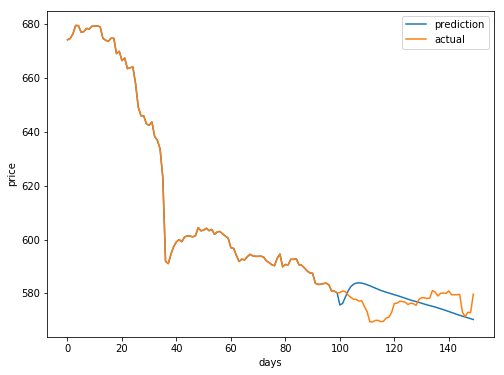

MAPE on sample 0.8976659558806404


In [25]:
random_state = 23

def viz_prediction(random_state):
    X_test, y_test = fetch_sample_boosted(df_train, 1, input_seq_len, output_seq_len, random_state)
    feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
    res = sess.run([reshaped_outputs], feed_dict=feed_dict)[0]
    res = np.array(res)
    # shape: (output_seq_len, batch_size, input_dim)
    res.transpose((1,0,2))
    X_plot = list(sc*X_test[:, 0, :].flatten() + me)[trend_memory:]
    y_plot = list(sc*y_test[:, 0, :].flatten() + me)
    y_pred = list(sc*res[:, 0, :].flatten() + me)
    plt.figure(figsize=(8,6))
    plt.plot(X_plot + y_pred, label='prediction')
    plt.plot(X_plot + y_plot, label='actual')
    plt.legend()
    plt.xlabel("days")
    plt.ylabel("price")
    plt.show()
    return (y_pred, y_plot)
    
y_pred, y_true = viz_prediction(random_state)
print("MAPE on sample", score_mape(y_pred, y_true, as_days=True))

## Evaluation

In [28]:
random_state = 188

# Eval on a full batch:
def eval_batch(random_state, batch_size):
    X_test, y_test = fetch_sample_boosted(df_test, batch_size, input_seq_len, output_seq_len, random_state=random_state)
    feed_dict = {encoder_inputs[t]: X_test[t] for t in range(len(encoder_inputs))}
    feed_dict.update({decoder_targets[t]: y_test[t] for t in range(len(decoder_targets))})
    res = sess.run([reshaped_outputs], feed_dict=feed_dict)[0]
    res = np.array(res)
    # shape: (output_seq_len, batch_size, input_dim)
    res.transpose((1,0,2))
    MAPE = 0
    for b in range(batch_size):
        y_true = list(sc*y_test[:, b, :].flatten() + me)
        y_pred = list(sc*res[:, b, :].flatten() + me)
        MAPE += score_mape(y_pred, y_true, as_days=True)
    return MAPE / batch_size

In [29]:
print("MAPE on 20 batch", eval_batch(random_state, 20))

MAPE on 20 batch 13.713518232858387
